In [42]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [43]:
from src.fewshot_ner_viz_component.data_processing import *
from src.fewshot_ner_viz_component.utils import *

In [44]:
TRAIN_ALL_ELMO_PARAMS = 1

In [45]:
tf.reset_default_graph()

In [46]:
sess = tf.Session()

In [47]:
# tf_vars = tf.trainable_variables()
# [v for v in tf_vars if 'my_var_name' in v.name][0]

In [48]:
module_path = "https://tfhub.dev/google/elmo/{}".format(1 if TRAIN_ALL_ELMO_PARAMS else 2)
elmo = hub.Module(module_path, trainable=True)

In [49]:
file_writer = tf.summary.FileWriter('./graph/elmo', tf.get_default_graph())

In [50]:
print(tf.trainable_variables())
elmo_vars = tf.trainable_variables()
vars_dict = {v.name:v for v in tf.trainable_variables()}
if(len(tf.trainable_variables()) > 0):
    elmo_params = {'layer_coefficients': tf.trainable_variables()[-2], 'scaling': tf.trainable_variables()[-1]}
    print(elmo_params)

[<tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>, <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>, <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0' shape=(4096, 512) dtype=float32>, <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>, <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>, <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0' shape=(4096, 512) dtype=float32>, <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>, <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>, <tf.Variable 'module/bilm/RNN_1/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/ke

In [51]:
print(vars_dict)

{'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0': <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>, 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0': <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>, 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0': <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/projection/kernel:0' shape=(4096, 512) dtype=float32>, 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0': <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0' shape=(1024, 16384) dtype=float32>, 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0': <tf.Variable 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/bias:0' shape=(16384,) dtype=float32>, 'module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/projection/kernel:0': <tf.Varia

In [52]:
if TRAIN_ALL_ELMO_PARAMS:
    cell0_kernel = vars_dict['module/bilm/RNN_0/RNN/MultiRNNCell/Cell0/rnn/lstm_cell/kernel:0']
    cell1_kernel = vars_dict['module/bilm/RNN_0/RNN/MultiRNNCell/Cell1/rnn/lstm_cell/kernel:0']

In [53]:
# for variable in tf.trainable_variables():
#     print(sess.run(variable))

### Prepare data

In [54]:
dataset_orig = read_data()
ne_type = 'PERSON'
dataset = filter_dataset_by_ne_types(dataset_orig, ne_type)

Num of train sentences: 75187
Num of valid sentences: 9603
Num of test sentences: 9479
[(['Actions', 'had', 'to', 'be', 'taken', 'to', 'break', 'through', 'the', 'blockade', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'a', 'night', 'in', 'late', 'July', '1940', ',', 'the', 'atmosphere', 'in', 'Zhuanbi', 'Village', 'in', 'Shaanxi', 'was', 'unusual', '.'], ['O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'B-GPE', 'I-GPE', 'O', 'B-GPE', 'O', 'O', 'O']), (['Villager', 'Xiao', 'Jianghe', 'has', 'a', 'vivid', 'memory', 'of', 'this', 'piece', 'of', 'history', '.'], ['O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'that', 'dark', 'night', ',', 'everyone', 'was', 'sleeping', 'when', 'human', 'voices', 'and', 'neighing', 'horses', 'were', 'heard', 'within', 'the', 'village', '.'], ['O', 'B-TIME', 'I-TIME', 'I-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

### Define computational graph

In [55]:
tokens_input = tf.placeholder(shape=[None, None], dtype=tf.string)
tokens_length = tf.placeholder(shape=[None], dtype=tf.int32)
y = tf.placeholder(shape=[None, None], dtype=tf.float32)

embeddings = elmo(inputs={"tokens": tokens_input,
                          "sequence_len": tokens_length},
                  signature="tokens",
                  as_dict=True)['elmo']

net = embeddings
# inp = tf.layers.dropout(inp, rate=0.5)
regularizer = tf.contrib.layers.l2_regularizer(scale=0.001)
# net = tf.layers.dense(net, 300, kernel_regularizer=regularizer)
# net = tf.layers.dense(net, 300, kernel_regularizer=regularizer)
out = tf.layers.dense(net, 1, kernel_regularizer=regularizer)
prob = tf.nn.sigmoid(out)
loss_tensor = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.expand_dims(y, axis=-1), logits=out)
loss_tensor = tf.squeeze(loss_tensor)
mask = tf.sequence_mask(lengths=tokens_length, dtype=tf.float32)
loss_tensor *= mask
loss = tf.reduce_mean(loss_tensor)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-24 17:02:02.214 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


In [56]:
all_vars = tf.trainable_variables()
model_vars = [v for v in all_vars if v not in elmo_vars]
print(model_vars)
vars_dict = {v.name:v for v in tf.trainable_variables()}

[<tf.Variable 'dense/kernel:0' shape=(1024, 1) dtype=float32_ref>, <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32_ref>]


In [57]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_op_all = optimizer.minimize(loss)
train_op_model = optimizer.minimize(loss, var_list=model_vars)

In [58]:
def predict_labels(prob: np.ndarray, threshold=0.5):
    labels = np.zeros(prob.shape)
    labels[prob > threshold] = 1
    return labels
def flat_array(a: np.ndarray):
#     return np.reshape(a, a.size)
    return a.flatten()
def calc_f1(y, pred_prob):
    return f1_score(flat_array(y), flat_array(predict_labels(pred_prob)))

In [59]:
def tags2binaryPadded(tags:list):
    if isinstance(tags[0], str):
        tags = [tags]
    n_sentences = len(tags)
    tokens_length = get_tokens_len(tags)
    max_len = np.max(tokens_length)
    tokens_length = np.tile(np.expand_dims(tokens_length, -1), (1,max_len))
    y = np.zeros((n_sentences, max_len))
    range_ar = np.tile(np.arange(1, max_len+1, 1), (n_sentences, 1))
    for i, sen in enumerate(tags):
        for j, tag in enumerate(sen):
            if tags[i][j] != 'O':
                y[i][j] = 1
#     y[range_ar > tokens_length] = -1
    return y

In [60]:
def get_batch(dataset, batch_size=None):
    if not batch_size:
        batch_size = len(dataset)
    tokens, tags = get_data_sample(dataset, batch_size)
    tokens_length = get_tokens_len(tokens)
    tokens = add_padding(tokens)
    y = tags2binaryPadded(tags)
    return tokens, tags, tokens_length, y

In [61]:
tokens_batch, tags_batch, tokens_len_batch, y_batch = get_batch(dataset['train'], 4)

In [62]:
# print(tokens_batch)

In [63]:
# print(tags_batch)

In [64]:
# print(y_batch)

In [65]:
valid_sen_size = 100
tokens_valid, tags_valid, tokens_len_valid, y_valid = get_batch(dataset['valid'], valid_sen_size)
feed_valid = {tokens_input: tokens_valid, tokens_length: tokens_len_valid, y: y_valid}

In [66]:
# Initialize variables
sess.run(tf.global_variables_initializer())

In [67]:
print(sess.run([elmo_params['layer_coefficients'], elmo_params['scaling']]))

[array([0., 0., 0.], dtype=float32), 1.0]


In [68]:
if TRAIN_ALL_ELMO_PARAMS:
    cell0_kernel_val0 = cell0_kernel.eval(session=sess)
    cell1_kernel_val0 = cell1_kernel.eval(session=sess)
    print(np.linalg.norm(cell0_kernel_val0))
    print(np.linalg.norm(cell1_kernel_val0))
    print(cell0_kernel_val0.shape)
    print(cell1_kernel_val0.shape)

315.50433
269.67868
(1024, 16384)
(1024, 16384)


In [69]:
# assign_op = elmo_params['layer_coefficients'].assign(np.array([1./3, 1./3, 1./3]))
# sess.run(assign_op)

In [70]:
# print(sess.run([elmo_params['layer_coefficients'], elmo_params['scaling']]))

In [71]:
def print_elmo_params():
    print('ELMo weights:')
    print(sess.run([elmo_params['layer_coefficients'], elmo_params['scaling']]))

In [72]:
num_steps = 300
n_steps_model_train = 100   # number of steps at the beginning then only model is trained
# num_steps = 10
batch_size = 4
display_step = 5
valid_step = 10
losses = {'train': [], 'valid': []}
f1_scores = {'train': [], 'valid': []}
best_valid_f1 = 0
d_elmo_cells_list = {'cell0':[], 'cell1':[]}
train_op = train_op_model
for step in range(1, num_steps+1):
    print('Step {}/{}'.format(step, num_steps))
    if step == n_steps_model_train+1:
        train_op = train_op_all
        print('START FINETUNING ELMo')
    tokens_batch, tags_batch, tokens_len_batch, y_batch = get_batch(dataset['train'], batch_size)
    feed = {tokens_input: tokens_batch, tokens_length: tokens_len_batch, y: y_batch}
    if TRAIN_ALL_ELMO_PARAMS:
        cell0_kernel_val1 = cell0_kernel.eval(session=sess)
        cell1_kernel_val1 = cell1_kernel.eval(session=sess)
    # Train
    with tf.variable_scope('', reuse=tf.AUTO_REUSE):
        loss_cur, prob_cur, _ = sess.run([loss, prob, train_op], feed_dict=feed)
        f1_train = calc_f1(y_batch, prob_cur)
    losses['train'].append(loss_cur)
    f1_scores['train'].append(f1_train)
    if TRAIN_ALL_ELMO_PARAMS:
        cell0_kernel_val2 = cell0_kernel.eval(session=sess)
        cell1_kernel_val2 = cell1_kernel.eval(session=sess)
        d_cell0_kernel = np.linalg.norm(cell0_kernel_val2 - cell0_kernel_val1)/np.linalg.norm(cell0_kernel_val1)
        d_cell1_kernel = np.linalg.norm(cell1_kernel_val2 - cell1_kernel_val1)/np.linalg.norm(cell1_kernel_val1)
        d_elmo_cells_list['cell0'].append(d_cell0_kernel)
        d_elmo_cells_list['cell1'].append(d_cell1_kernel)
#     print('ELMo cells change per step: cell0: {}, cell1: {}'.format(d_cell0_kernel, d_cell1_kernel))
    # Validate
    with tf.variable_scope('', reuse=tf.AUTO_REUSE):
        loss_valid, prob_valid = sess.run([loss, prob], feed_dict=feed_valid)
        f1_valid = calc_f1(y_valid, prob_valid)
    # Get elmo params
    with tf.variable_scope('', reuse=tf.AUTO_REUSE):
        layer_coeff, scale = sess.run([elmo_params['layer_coefficients'], elmo_params['scaling']])
    if f1_valid > best_valid_f1:
        best_valid_f1 = f1_valid
        elmo_params_best = {'layer_coefficients': layer_coeff, 'scaling': scale}
    losses['valid'].append(loss_valid)
    f1_scores['valid'].append(f1_valid) 
    if step % display_step == 0 or step == 1:
        print('Train loss = {}'.format(losses['train'][-1]))
        print('Train F1 score = {}'.format(f1_scores['train'][-1]))
        with tf.variable_scope('', reuse=tf.AUTO_REUSE):
            print('ELMo weights:')
            print('Coefficients = {}, scale = {}'.format(layer_coeff, scale))
        if TRAIN_ALL_ELMO_PARAMS:
            print('ELMo cells change per step: cell0: {:.2f}%, cell1: {:.2f}%'.format(d_cell0_kernel*100, d_cell1_kernel*100))
        
    if step % valid_step == 0 or step == 1:
        print('Valid loss = {}'.format(losses['valid'][-1]))
        print('Valid F1 score = {}'.format(f1_scores['valid'][-1]))

Step 1/300
Train loss = 0.5990773439407349
Train F1 score = 0.18181818181818182
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Valid loss = 0.15798191726207733
Valid F1 score = 0.13317757009345796
Step 2/300
Step 3/300
Step 4/300
Step 5/300
Train loss = 0.3960040211677551
Train F1 score = 0.28571428571428575
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Step 6/300
Step 7/300
Step 8/300
Step 9/300
Step 10/300
Train loss = 0.4236142039299011
Train F1 score = 0.1111111111111111
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Valid loss = 0.12269383668899536
Valid F1 score = 0.22304832713754646
Step 11/300
Step 12/300
Step 13/300
Step 14/300


/home/clement/virtenv/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Step 15/300
Train loss = 0.3575887084007263
Train F1 score = 0.0
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Step 16/300
Step 17/300
Step 18/300
Step 19/300
Step 20/300
Train loss = 0.3664196729660034
Train F1 score = 0.0
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Valid loss = 0.09352946281433105
Valid F1 score = 0.369077306733167
Step 21/300
Step 22/300
Step 23/300
Step 24/300
Step 25/300
Train loss = 0.37170085310935974
Train F1 score = 0.2857142857142857
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Step 26/300
Step 27/300
Step 28/300
Step 29/300
Step 30/300
Train loss = 0.244896799325943
Train F1 score = 0.4
ELMo weights:
Coefficients = [0. 0. 0.], scale = 1.0
ELMo cells change per step: cell0: 0.00%, cell1: 0.00%
Valid loss = 0.07586058229207993
Valid F1 score = 0.4867724867724868
Step 31/300


Step 162/300
Step 163/300
Step 164/300
Step 165/300
Train loss = 0.20750316977500916
Train F1 score = 0.5
ELMo weights:
Coefficients = [ 0.0558515   0.03438013 -0.05198459], scale = 0.9468861222267151
ELMo cells change per step: cell0: 0.34%, cell1: 0.47%
Step 166/300
Step 167/300
Step 168/300
Step 169/300
Step 170/300
Train loss = 0.0339282862842083
Train F1 score = 0.923076923076923
ELMo weights:
Coefficients = [ 0.06236743  0.03468477 -0.05856427], scale = 0.9409354329109192
ELMo cells change per step: cell0: 0.21%, cell1: 0.33%
Valid loss = 0.03862747177481651
Valid F1 score = 0.8125
Step 171/300
Step 172/300
Step 173/300
Step 174/300
Step 175/300
Train loss = 0.051127806305885315
Train F1 score = 0.8
ELMo weights:
Coefficients = [ 0.06683799  0.03499591 -0.06314357], scale = 0.9369228482246399
ELMo cells change per step: cell0: 0.13%, cell1: 0.22%
Step 176/300
Step 177/300
Step 178/300
Step 179/300
Step 180/300
Train loss = 0.006711234804242849
Train F1 score = 1.0
ELMo weights:
C

Step 297/300
Step 298/300
Step 299/300
Step 300/300
Train loss = 0.011031320318579674
Train F1 score = 1.0
ELMo weights:
Coefficients = [ 0.08653649  0.04220517 -0.08641932], scale = 0.9182690978050232
ELMo cells change per step: cell0: 0.05%, cell1: 0.16%
Valid loss = 0.017028113827109337
Valid F1 score = 0.8955823293172691


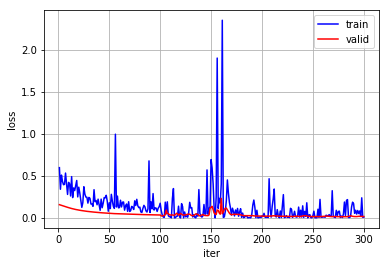

In [73]:
# Plot learning curve
plt.figure()
steps = np.arange(1, num_steps+1, 1)
plt.plot(steps, losses['train'], c='b', label='train')
plt.plot(steps, losses['valid'], c='r', label='valid')
plt.xlabel('iter')
plt.ylabel('loss')
plt.grid()
plt.legend()

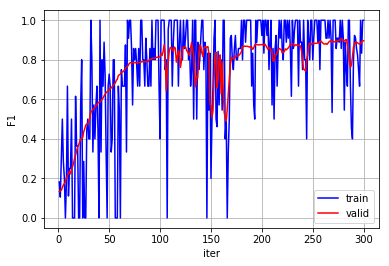

In [74]:
# Plot F1 scores
plt.figure()
steps = np.arange(1, num_steps+1, 1)
plt.plot(steps, f1_scores['train'], c='b', label='train')
plt.plot(steps, f1_scores['valid'], c='r', label='valid')
plt.xlabel('iter')
plt.ylabel('F1')
plt.grid()
plt.legend()

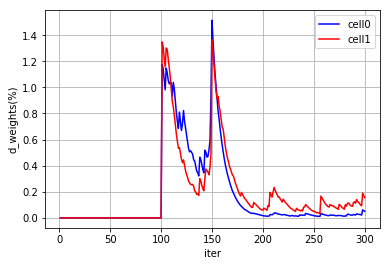

In [75]:
# Plot elmo cells changes per step
if TRAIN_ALL_ELMO_PARAMS:
    plt.figure()
    steps = np.arange(1, num_steps+1, 1)
    plt.plot(steps, np.array(d_elmo_cells_list['cell0'])*100, c='b', label='cell0')
    plt.plot(steps, np.array(d_elmo_cells_list['cell1'])*100, c='r', label='cell1')
    plt.xlabel('iter')
    plt.ylabel('d_weights(%)')
    plt.grid()
    plt.legend()

In [76]:
file_writer = tf.summary.FileWriter('./graph/all', tf.get_default_graph())

In [77]:
print('Best F1 score on validation: {:.2f}'.format(best_valid_f1*100))
elmo_layer_coeff = np.exp(elmo_params_best['layer_coefficients'])*elmo_params_best['scaling']
print('Learned ELMo layer combination weights:')
print(elmo_layer_coeff)

Best F1 score on validation: 90.67
Learned ELMo layer combination weights:
[1.0018864  0.96138704 0.84934336]


#### Test model

In [78]:
# tokens_test, tags_test, tokens_len_test, y_test = get_batch(dataset['test'])
# feed_test = {tokens_input: tokens_test, tokens_length: tokens_len_test, y: y_test}

In [79]:
# def get_batch_gen(dataset, shuffle=False, batch_size=None):
#     indices = len(dataset)
#     k = 0
#     while k < len(indices):
#         top = k + batch_size if k + batch_size < len(indices) or len(indices)-1
#         batch = dataset[indices[k:top]]
#         yield 
#         k += batch_size

In [80]:
# with tf.variable_scope('', reuse=tf.AUTO_REUSE):
#     loss_test, prob_test = sess.run([loss, prob], feed_dict=feed_test)
#     f1_test = calc_f1(y_test, prob_test)

In [81]:
# print(len(dataset['test']))

In [82]:
# print('Test F1 = {:.2f}'.format(f1_test*100))